In [1]:
import SimpleITK as sitk

import numpy as np
import matplotlib.animation as animation
import skimage.io as io
import os
from IPython.display import HTML

import os
OUTPUT_DIR = 'Output'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    #img = (1.0 - alpha)*fixed[:,:,image_z] + (alpha)*moving[:,:,image_z] 
    fixed = sitk.GetArrayViewFromImage(fixed)
    moving = sitk.GetArrayViewFromImage(moving)
    img = (1.0 - alpha)*fixed[image_z,:,:] + (alpha)*moving[image_z,:,:]
    plt.imshow(img,cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do clean up of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
current_dir = os.getcwd()
#print(current_dir)

t1_file = "CHB/CHB_train_Case01/CHB_train_Case01_T1.nhdr"
t2_file = "CHB/CHB_train_Case01/CHB_train_Case01_T2.nhdr"
flair_file = "CHB/CHB_train_Case01/CHB_train_Case01_FLAIR.nhdr"
lesion_file = "CHB/CHB_train_Case01/CHB_train_Case01_lesion.nhdr"

t1_itk = sitk.ReadImage(current_dir+"/"+t1_file)
t2_itk = sitk.ReadImage(current_dir+"/"+t2_file)
img_flair = sitk.ReadImage(current_dir+"/"+flair_file)
img_lesion = sitk.ReadImage(current_dir+"/"+lesion_file)

In [4]:
fixed_image =  t1_itk
moving_image = t2_itk

interact(display_images, 
         fixed_image_z=(0,fixed_image.GetSize()[2]-1), 
         moving_image_z=(0,moving_image.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), 
         moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

Widget Javascript not detected.  It may not be installed or enabled properly.


In [5]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# print(moving_resampled)

interact(display_images_with_alpha, 
         image_z=(0,fixed_image.GetSize()[2]-1), 
         alpha=(0.0,1.0,0.05), 
         fixed = fixed(fixed_image), 
         moving=fixed(moving_resampled));

Image (0x3dba410)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 1577
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1566
  UpdateMTime: 1576
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 512]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 512]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 512]
  Spacing: [0.5, 0.5, 0.5]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.5 0 0
0 0.5 0
0 0 0.5

  PointToIndexMatrix: 
2 0 0
0 2 0
0 0 2

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x3653a80)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
      Modified Time: 1573
      Debug: O

Widget Javascript not detected.  It may not be installed or enabled properly.


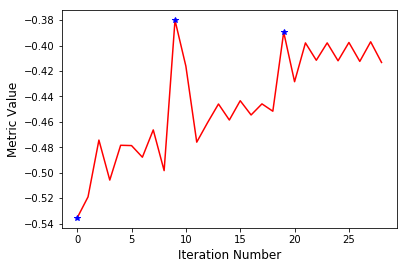

In [6]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01, numberOfIterations=10, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [7]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.413327302132958
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (10) exceeded.


In [8]:
moving_resampled = sitk.Resample(moving_image, fixed_image, 
                                 final_transform, sitk.sitkLinear, 
                                 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), 
         alpha=(0.0,1.0,0.05), 
         fixed = fixed(fixed_image), moving=fixed(moving_resampled));

Widget Javascript not detected.  It may not be installed or enabled properly.
